In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json
import pandas as pd
import xgboost as xgb

In [2]:
with open('/home/taeun8991/descriptor_model/vectorization_1/x_vector_crystal_size', 'r') as file:
    x_vector = json.load(file)

with open('/home/taeun8991/descriptor_model/vectorization_1/y_vector_crystal_size', 'r') as file:
    y_vector = json.load(file)

with open('/home/taeun8991/descriptor_model/vectorization_1/refcode_list_crystal_size', 'r') as f:
    refcode_list = json.load(f)

In [19]:
# Load the dictionaries and list from the JSON files
with open('/home/taeun8991/pmtf/crystal_size_log/test_crystal_size_log.json', 'r') as f:
    test_dict = json.load(f)

# Get the keys from the test_density_30000.json dictionary
test_keys = list(test_dict.keys())

# Get the indices of the keys in the refcode_list_density.json list
test_indices = [refcode_list.index(key) for key in test_keys]

X_test_before = [x_vector[i] for i in test_indices]
y_test_before = [y_vector[i] for i in test_indices]

train_indices = [i for i in range(len(x_vector)) if i not in test_indices] # refcode_list[i] not in exclude_keys and
X_train_before = [x_vector[i] for i in train_indices]
y_train_before = [y_vector[i] for i in train_indices]

# Filter out invalid sublists
filtered_indices_test = [
    i for i, sublist in enumerate(X_test_before) 
    if not any(
        (isinstance(value, (float, int)) and (np.isinf(value) or np.abs(value) > np.finfo(np.float32).max or np.isnan(value) or value == 'nan'))
        for value in sublist
    )
]

filtered_indices_train = [
    i for i, sublist in enumerate(X_train_before) 
    if not any(
        (isinstance(value, (float, int)) and (np.isinf(value) or np.abs(value) > np.finfo(np.float32).max or np.isnan(value) or value == 'nan'))
        for value in sublist
    )
]

X_test_after = [X_test_before[i] for i in filtered_indices_test]
y_test_after = [y_test_before[i] for i in filtered_indices_test]


X_train_after = [X_train_before[i] for i in filtered_indices_train]
y_train_after = [y_train_before[i] for i in filtered_indices_train]

# Convert filtered lists to arrays
X_trainval = np.array(X_train_after).astype(float)
y_trainval = np.array(y_train_after).astype(float)
X_test = np.array(X_test_after).astype(float)
y_test = np.array(y_test_after).astype(float)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=20)

In [20]:
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
gbm_model_exp.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Evaluate on the train set
y_train_pred_exp = gbm_model_exp.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_exp)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred_exp)
print("Train Mean Squared Error:", train_mse)
print("Train Root Mean Square Error:",train_rmse)
print("Train R-squared (R2):", train_r2)

# After hyperparameter tuning, evaluate the final model on the test set
y_test_pred_exp = gbm_model_exp.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_exp)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred_exp)
print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Square Error:",test_rmse)
print("Test R-squared (R2):", test_r2)

/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train Mean Squared Error: 1.476486091961859
Train Root Mean Square Error: 1.2151074405013982
Train R-squared (R2): 0.6383610858616917
Test Mean Squared Error: 3.856548659057335
Test Root Mean Square Error: 1.9638097308693974
Test R-squared (R2): -0.014111900550197731


/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


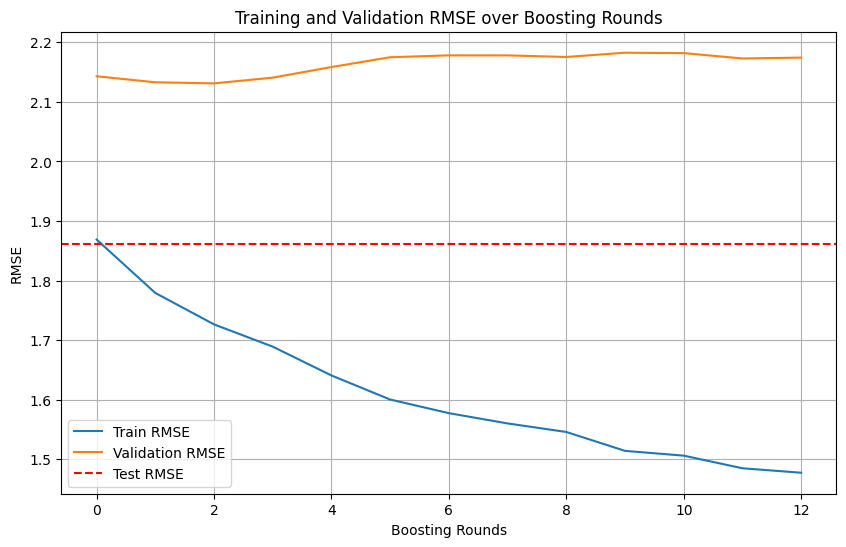

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize XGBoost model
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
evals_result = {}
gbm_model_exp.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Extract training and validation RMSE from the model's evaluation history
train_rmse = gbm_model_exp.evals_result()['validation_0']['rmse']
val_rmse = gbm_model_exp.evals_result()['validation_1']['rmse']

# Calculate RMSE on the test set
test_rmse = mean_squared_error(y_test, gbm_model_exp.predict(X_test), squared=False)

# Plot training and validation RMSE over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
plt.plot(range(len(val_rmse)), val_rmse, label='Validation RMSE')
plt.axhline(test_rmse, color='red', linestyle='--', label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
len(y_val)+len(y_test)+len(y_train)

9631

In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=400)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Evaluate on the train set
y_train_pred = rf_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_exp)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred_exp)
print("Train Mean Squared Error:", train_mse)
print("Train Root Mean Square Error:",train_rmse)
print("Train R-squared (R2):", train_r2)

# After hyperparameter tuning, evaluate the final model on the test set
y_test_pred = rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred_exp)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred_exp)
print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Square Error:",test_rmse)
print("Test R-squared (R2):", test_r2)

Train Mean Squared Error: 1.4693289030792946
Train Root Mean Square Error: 1.212158777998697
Train R-squared (R2): 0.6374603158257305
Test Mean Squared Error: 3.305483651890474
Test Root Mean Square Error: 1.8180989114705708
Test R-squared (R2): 0.1307952771233475


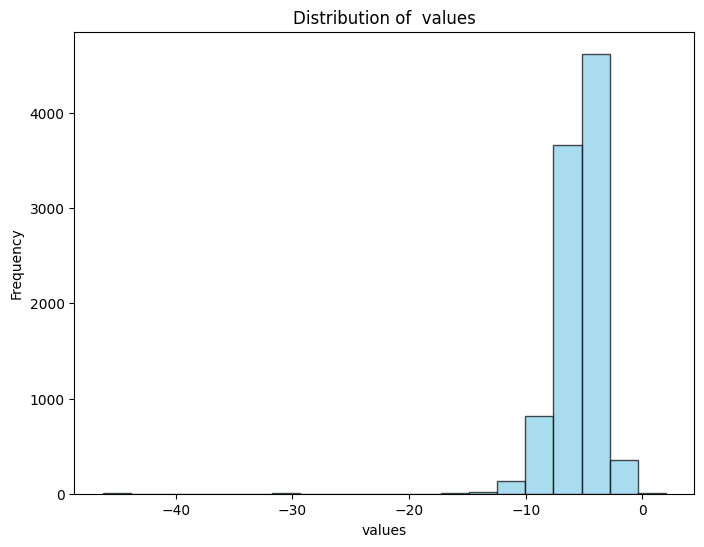

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Combine y_train, y_val, and y_test into a single array
combined_y = np.concatenate([y_train, y_val, y_test])

# Plot the distribution of combined y
plt.figure(figsize=(8, 6))
plt.hist(combined_y, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('values')
plt.ylabel('Frequency')
plt.title('Distribution of  values')
# plt.grid(True)
plt.show()


In [12]:
# Calculate quartiles (25th, 50th, and 75th percentiles) of combined y
q1 = np.percentile(combined_y, 25)
q2 = np.percentile(combined_y, 50)
q3 = np.percentile(combined_y, 75)

# Calculate the minimum and maximum values of combined y
q1_min = np.percentile(combined_y, 0)
q1_max = np.percentile(combined_y, 25)

q2_min = np.percentile(combined_y, 25)
q2_max = np.percentile(combined_y, 50)

q3_min = np.percentile(combined_y, 50)
q3_max = np.percentile(combined_y, 75)

q4_min = np.percentile(combined_y, 75)
q4_max = np.percentile(combined_y, 100)

# Print the range of each quartile
print("Range of 1st Quartile (Q1):", q1_min, "-", q1_max)
print("Range of 2nd Quartile (Q2, Median):", q2_min, "-", q2_max)
print("Range of 3rd Quartile (Q3):", q3_min, "-", q3_max)
print("Range of 4th Quartile (Q4):", q4_min, "-", q4_max)

Range of 1st Quartile (Q1): -46.27734854141324 - -6.294691347739308
Range of 2nd Quartile (Q2, Median): -6.294691347739308 - -5.115995809754082
Range of 3rd Quartile (Q3): -5.115995809754082 - -4.236103584513799
Range of 4th Quartile (Q4): -4.236103584513799 - 2.0483377966285023


In [16]:
# Calculate the indices where y falls within the range of Q2
q2_indices_train = np.where((y_train >= q2_min) & (y_train <= q3_max))[0]
q2_indices_val = np.where((y_val >= q2_min) & (y_val <= q3_max))[0]
q2_indices_test = np.where((y_test >= q2_min) & (y_test <= q3_max))[0]


# Extract the corresponding data from X_train, X_val, X_test, y_train, y_val, and y_test
X_train_q2 = X_train[q2_indices_train]
X_val_q2 = X_val[q2_indices_val]
X_test_q2 = X_test[q2_indices_test]
y_train_q2 = y_train[q2_indices_train]
y_val_q2 = y_val[q2_indices_val]
y_test_q2 = y_test[q2_indices_test]

In [17]:
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
gbm_model_exp.fit(X_train_q2, y_train_q2, eval_set=[(X_val_q2, y_val_q2)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Evaluate on the train set
y_train_q2_pred_exp = gbm_model_exp.predict(X_train_q2)
train_mse = mean_squared_error(y_train_q2, y_train_q2_pred_exp)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_q2, y_train_q2_pred_exp)
print("Train Mean Squared Error:", train_mse)
print("Train Root Mean Square Error:",train_rmse)
print("Train R-squared (R2):", train_r2)

# After hyperparameter tuning, evaluate the final model on the test set
y_test_q2_pred_exp = gbm_model_exp.predict(X_test_q2)
test_mse = mean_squared_error(y_test_q2, y_test_q2_pred_exp)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_q2, y_test_q2_pred_exp)
print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Square Error:",test_rmse)
print("Test R-squared (R2):", test_r2)

/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train Mean Squared Error: 0.24716399558000438
Train Root Mean Square Error: 0.4971559067133814
Train R-squared (R2): 0.2674229438018816
Test Mean Squared Error: 0.3132012788990402
Test Root Mean Square Error: 0.559643885787239
Test R-squared (R2): 0.03579905845319353


/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/taeun8991/anaconda3/envs/feature_extraction/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


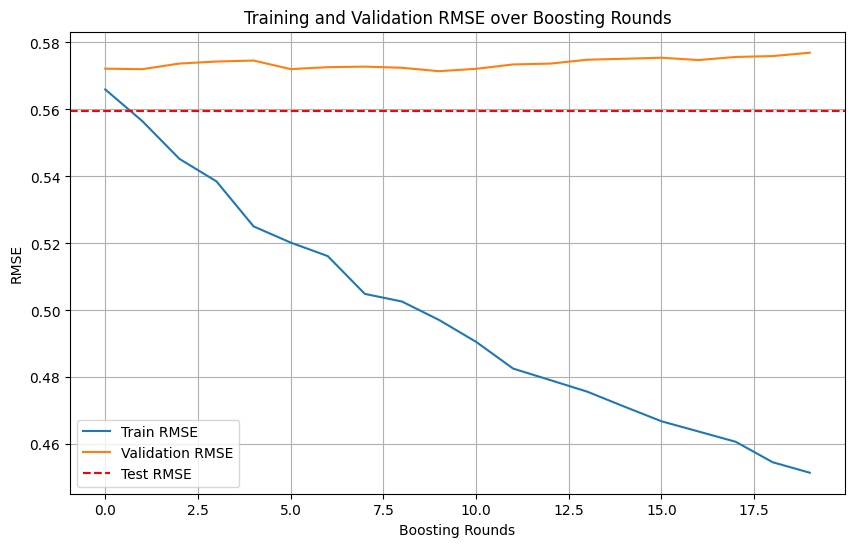

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize XGBoost model
gbm_model_exp = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the training set and evaluate on the validation set
evals_result = {}
gbm_model_exp.fit(X_train_q2, y_train_q2, eval_set=[(X_train_q2, y_train_q2), (X_val_q2, y_val_q2)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)

# Extract training and validation RMSE from the model's evaluation history
train_rmse = gbm_model_exp.evals_result()['validation_0']['rmse']
val_rmse = gbm_model_exp.evals_result()['validation_1']['rmse']

# Calculate RMSE on the test set
test_rmse = mean_squared_error(y_test_q2, gbm_model_exp.predict(X_test_q2), squared=False)

# Plot training and validation RMSE over boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
plt.plot(range(len(val_rmse)), val_rmse, label='Validation RMSE')
plt.axhline(test_rmse, color='red', linestyle='--', label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()